In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
if 'google.colab' in sys.modules:
  if not os.path.isdir('/content/drive/'):
    from google.colab import drive
    drive.mount('/content/drive/')

  %cd /content/drive/MyDrive/engg680_course_project/

In [ ]:
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F

from input import Input_Data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load data and initialize data splits
data = Input_Data()
data.load_data("./models/station_features_v2.csv")
data.init_split()

In [ ]:
from stt import PM25TransformerModel, batch_size, block_size, stations_in_batch, target_size

torch.no_grad() # Disable gradient computation for inference
transformer_model = PM25TransformerModel(data)  # Initialize the PM2.5 Transformer model
transformer_model.load_state_dict(torch.load("./models/five_years.model", weights_only=True))
transformer_model.to(device)  # Move model to the appropriate device (CPU/GPU)
transformer_model.eval() # Set model to evaluation mode

with open("./models/transformer_losses.loss", "rb") as fp:
    transformer_losses = pickle.load(fp)

print("Done")

Done


In [ ]:
from linear import LinearModel, batch_size, block_size

torch.no_grad()
linear_model = LinearModel(data)
linear_model.load_state_dict(torch.load("./models/five_years_linear.model", weights_only=True))
linear_model.to(device)
linear_model.eval()

with open("./models/linear_losses.loss", "rb") as fp:
    linear_losses = pickle.load(fp)

print("Done")

Done


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Function to calculate Root Mean Squared Error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Function to evaluate the test error for a given model
def test_error(model):
    torch.manual_seed(1337)
    iter = 500

# Initialize tensors to store different metrics
    mse_losses = torch.zeros(iter)
    r2_losses = torch.zeros(iter)
    mae_losses = torch.zeros(iter)
    rmse_losses = torch.zeros(iter)
    mape_losses = torch.zeros(iter)

    all_targets = []
    all_preds = []

# Iterate over batches for evaluation
    for k in range(iter):
        batch = data.get_batch('test', batch_size, block_size, target_size, device)
        logits, mse_loss, r2 = model(batch)
        targets, _ = torch.split(batch[1], 1, dim=-1)
        targets = targets.detach().cpu().numpy().flatten()
        preds = logits.detach().cpu().numpy().flatten()

        all_targets.append(targets)
        all_preds.append(preds)

        mse_losses[k] = mse_loss.item()
        r2_losses[k] = r2
        mae_losses[k] = mean_absolute_error(targets, preds)
        rmse_losses[k] = rmse(targets, preds)
        mape_losses[k] = mean_absolute_percentage_error(targets, preds)

    print(f"MSE: {mse_losses.mean()}")
    print(f"r2: {r2_losses.mean()}")
    print(f"MAE: {mae_losses.mean()}")
    print(f"RMSE: {rmse_losses.mean()}")
    print(f"MAPE: {mape_losses.mean()}%")

    return type('TestErrorResult', (), {'all_targets': np.concatenate(all_targets), 'all_preds': np.concatenate(all_preds)})

print("Transformer model")
test_error(transformer_model)

print("Linear Model")
test_error(linear_model)

Transformer model
MSE: 2.5075305529753678e-05
r2: -0.48370426893234253
MAE: 4.161135673522949
RMSE: 6.994561195373535
MAPE: 97216782336.0%
Linear Model
MSE: 3.324101385260292e-07
r2: 0.9605646729469299
MAE: 6.874059677124023
RMSE: 9.481644630432129
MAPE: 4879744.5%


__main__.TestErrorResult

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def gen_24(model):
    torch.manual_seed(1337)
    iter = 500
    hours = 24

    mse_losses = torch.zeros(iter)
    r2_losses = torch.zeros(iter)
    mae_losses = torch.zeros(iter)
    rmse_losses = torch.zeros(iter)
    mape_losses = torch.zeros(iter)

    all_targets = []
    all_preds = []

    for k in range(iter):
        batch = data.get_batch_target('test', batch_size, block_size, hours, device)
        gen = model.generate(batch, hours)

        targets, _ = torch.split(batch[1], 1, dim=-1)
        targets = targets.view(batch_size, hours)
        targets_1 = targets.detach().cpu().numpy().flatten()
        preds = gen.detach().cpu().numpy().flatten()
        all_targets.append(targets_1)
        all_preds.append(preds)

        mse_loss = model.mse_loss(model.normalize(gen), model.normalize(targets))
        mse_losses[k] = mse_loss.item()
        r2_losses[k] = r2_score(targets.detach().cpu().numpy().flatten(), gen.detach().cpu().numpy().flatten())
        mae_loss = mean_absolute_error(targets.detach().cpu().numpy().flatten(), gen.detach().cpu().numpy().flatten())
        mae_losses[k] = mae_loss
        rmse_loss = np.sqrt(mean_squared_error(targets.detach().cpu().numpy().flatten(), gen.detach().cpu().numpy().flatten()))
        rmse_losses[k] = rmse_loss
        mape_loss = mean_absolute_percentage_error(targets.detach().cpu().numpy().flatten(), gen.detach().cpu().numpy().flatten())
        mape_losses[k] = mape_loss

    print(f"MSE: {mse_losses.mean()}")
    print(f"r2: {r2_losses.mean()}")
    print(f"MAE: {mae_losses.mean()}")
    print(f"RMSE: {rmse_losses.mean()}")
    print(f"MAPE: {mape_losses.mean()}%")

    return type('Gen24Result', (), {'all_targets': np.concatenate(all_targets),'all_preds': np.concatenate(all_preds)})

print("Transformer model")
gen_24(transformer_model)

print("Linear Model")
gen_24(linear_model)

Transformer model
MSE: 2.6212141165160574e-05
r2: -0.4482114911079407
MAE: 4.229403972625732
RMSE: 7.198902130126953
MAPE: 437565463199744.0%
Linear Model
MSE: 6.177249451866373e-05
r2: -6.84506893157959
MAE: 8.945686340332031
RMSE: 11.832280158996582
MAPE: 608864630210560.0%


__main__.Gen24Result

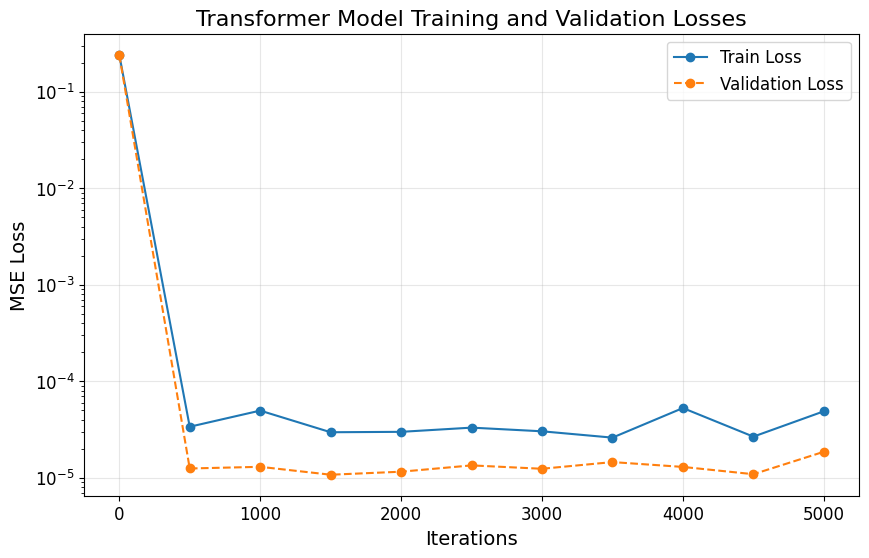

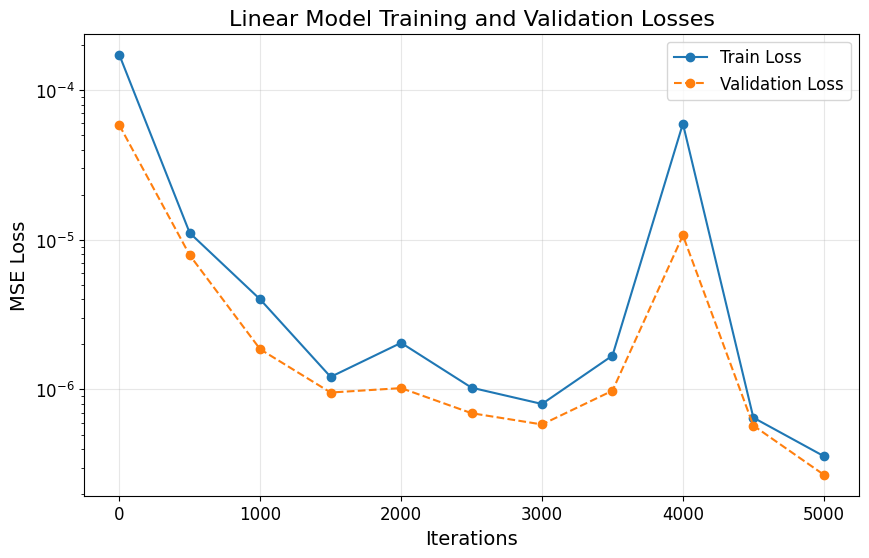

In [ ]:
import matplotlib.pyplot as plt

def train_val_loss_graph(losses, name):
    # Example loss lists (replace these with your actual data)
    # Assuming each entry corresponds to the loss value at 500 iterations
    train_losses = [item['train'][0].item() for item in losses]
    val_losses = [item['val'][0].item() for item in losses]

    # Define the iteration checkpoints
    iterations = [500 * (i) for i in range(len(losses))]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.plot(iterations, val_losses, label='Validation Loss', marker='o', linestyle='--')

    plt.yscale('log')

    # Formatting
    plt.title(name, fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('MSE Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show plot
    plt.show()

train_val_loss_graph(transformer_losses, 'Transformer Model Training and Validation Losses')
train_val_loss_graph(linear_losses, 'Linear Model Training and Validation Losses')

MSE: 2.5075305529753678e-05
r2: -0.48370426893234253
MAE: 4.161135673522949
RMSE: 6.994561195373535
MAPE: 437825442938880.0%
MSE: 2.5075305529753678e-05
r2: -0.48370426893234253
MAE: 4.161135673522949
RMSE: 6.994561195373535
MAPE: 437825442938880.0%
MSE: 3.324101385260292e-07
r2: 0.9605646729469299
MAE: 6.874059677124023
RMSE: 9.481644630432129
MAPE: 21975975936.0%
MSE: 2.6212141165160574e-05
r2: -0.4482114911079407
MAE: 4.229403972625732
RMSE: 7.198902130126953
MAPE: 437565463199744.0%
MSE: 2.6212141165160574e-05
r2: -0.4482114911079407
MAE: 4.229403972625732
RMSE: 7.198902130126953
MAPE: 437565463199744.0%
MSE: 6.177249451866373e-05
r2: -6.84506893157959
MAE: 8.945686340332031
RMSE: 11.832280158996582
MAPE: 608864630210560.0%


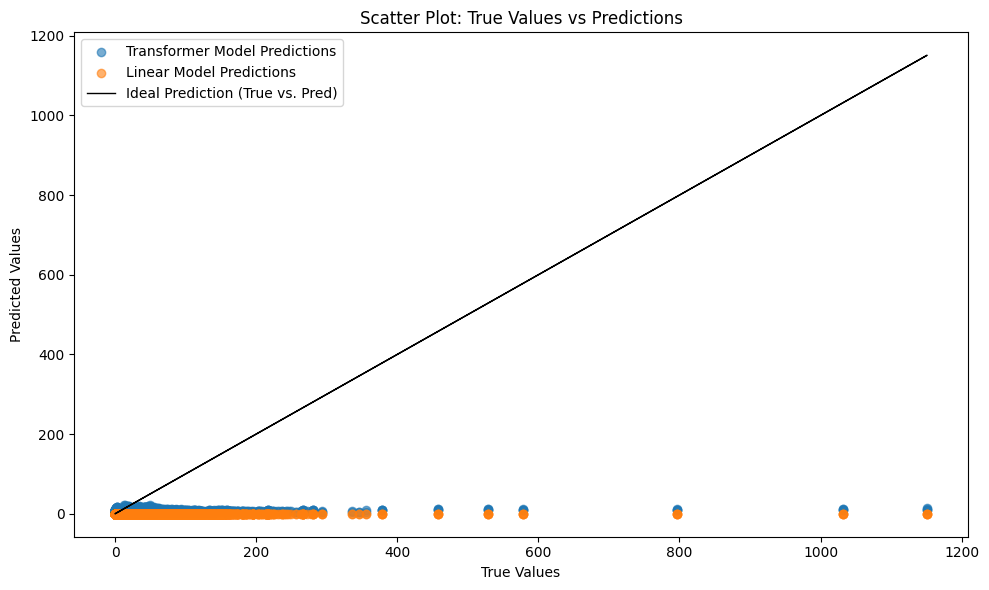

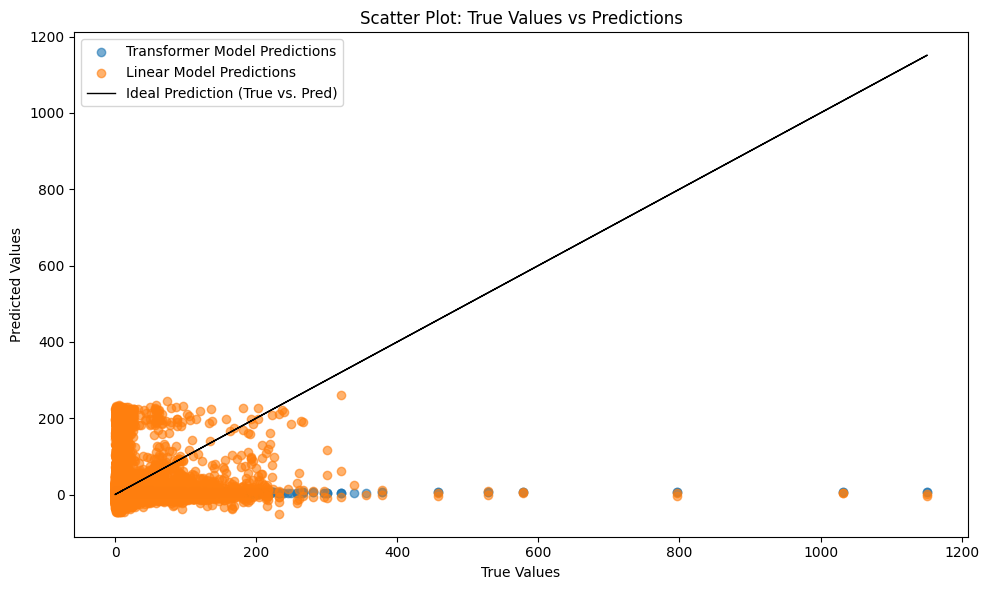

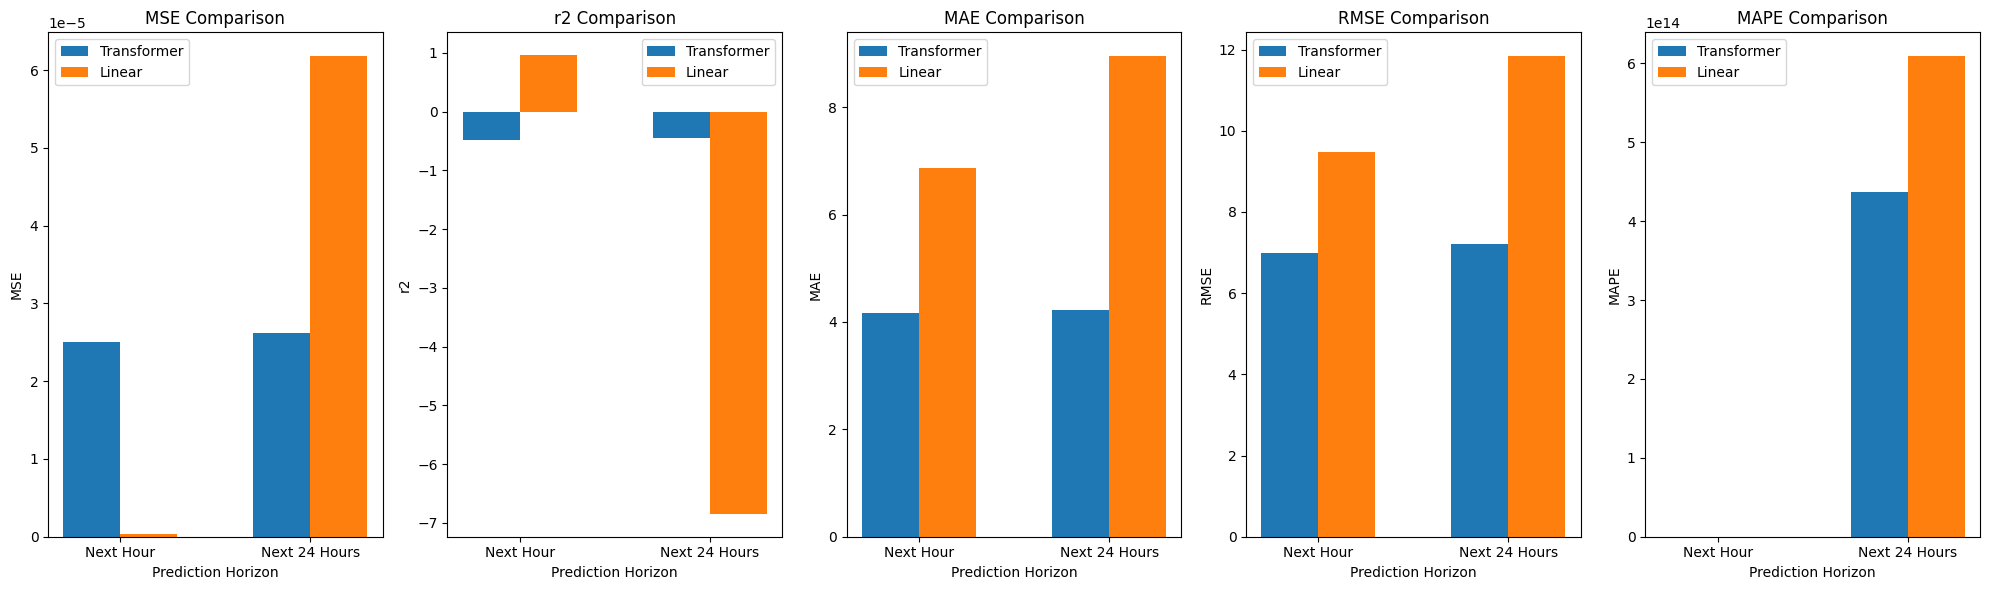

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MSE', 'r2', 'MAE', 'RMSE', 'MAPE']

def plot_scatter(true_values, transformer_preds, linear_preds):
    # Scatter plot for true values vs. predictions from both models
    plt.figure(figsize=(10, 6))

    plt.scatter(true_values, transformer_preds, label='Transformer Model Predictions', alpha=0.6)
    plt.scatter(true_values, linear_preds, label='Linear Model Predictions', alpha=0.6)

    plt.plot(true_values, true_values, color='black', linewidth=1, label='Ideal Prediction (True vs. Pred)')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: True Values vs Predictions')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_comparison_bar_chart(transformer_values, linear_values, transformer_values_24, linear_values_24):
    # Create subplots for each metric (5 subplots)
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), dpi=100)

    # Iterate through each metric
    for i, metric in enumerate(metrics):
        # Select the appropriate axis for plotting
        ax = axes[i]

        # Define the bar positions
        bar_width = 0.3
        index = np.arange(2)  # We will have two bars per metric: one for next hour, one for 24 hours

        # Data for the bars
        transformer_data = [transformer_values[i], transformer_values_24[i]]
        linear_data = [linear_values[i], linear_values_24[i]]

        # Plot the bars for Transformer and Linear models
        ax.bar(index - bar_width/2, transformer_data, bar_width, label='Transformer')
        ax.bar(index + bar_width/2, linear_data, bar_width, label='Linear')

        # Set title and labels
        ax.set_title(f'{metric} Comparison')
        ax.set_xticks(index)
        ax.set_xticklabels(['Next Hour', 'Next 24 Hours'])
        ax.set_xlabel('Prediction Horizon')
        ax.set_ylabel(metric)
        ax.legend()

    plt.tight_layout()
    plt.show()

true_values_1 = test_error(transformer_model).all_targets
transformer_preds = test_error(transformer_model).all_preds
linear_preds = test_error(linear_model).all_preds
transformer_values = [2.5075305529753678e-05, -0.48370426893234253, 4.161135673522949, 6.994561195373535, 97216782336.0]
linear_values = [3.324101385260292e-07, 0.9605646729469299, 6.874059677124023, 9.481644630432129, 4879744.5]

true_values_2 = gen_24(transformer_model).all_targets
transformer_preds_24 = gen_24(transformer_model).all_preds
linear_preds_24 = gen_24(linear_model).all_preds
transformer_values_24 = [2.6212141165160574e-05, -0.4482114911079407, 4.229403972625732, 7.198902130126953, 437565463199744.0]
linear_values_24 = [6.177249451866373e-05, -6.84506893157959, 8.945686340332031, 11.832280158996582, 608864630210560.0]

plot_scatter(true_values_1, transformer_preds, linear_preds)
plot_scatter(true_values_2, transformer_preds_24, linear_preds_24)

plot_comparison_bar_chart(transformer_values, linear_values, transformer_values_24, linear_values_24)
